# Imports

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_style('white')

# Data Cleaning

In [2]:
conn = sqlite3.connect('Data/HMTG_possib_remote_pilot1.db')
dat = pd.read_sql_query('SELECT * FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.bonus NOTNULL', conn)
dat = dat.astype({'trl': int})


### Make sure all subjects have 45 trials. group by trustee observed

In [3]:
# Drop any subject with less than 45 trials
for trustee in dat.trustee_id.unique():
    for subject in dat.loc[dat.trustee_id == trustee].subject_id.unique():
        if dat.loc[dat.subject_id==subject].trl.max() != 44:
            dat.drop(dat.index[dat['subject_id'] == subject], inplace=True)

dat = dat.loc[dat.subID != 'prolific_subject'].reset_index(drop=True)

# Add Trustee Strategy
p2s = {54:'opportunist', 62:'greedy', 93:'GA', 97:'IA'}
dat['p2_strategy'] = dat.trustee_id.apply(lambda x: p2s[x])

sub_count = dat.groupby('trustee_id').agg(({"subject_id": "nunique"}))
sub_count

,subject_id
trustee_id,
54,19
62,19
93,22
97,13


### Make sure each trustee was observed by the same number of subject

In [4]:
# Ensure that each trustee was viewed by the same amount of subjects
n = sub_count.subject_id.min()

for trustee in dat.trustee_id.unique():
    subs_x_trustee = len(dat.loc[dat.trustee_id == trustee].subject_id.unique()) # number of subjects who viewed a single trustee
    if subs_x_trustee > n:
        indx2drop = np.random.choice(range(subs_x_trustee), size=(subs_x_trustee-n), replace=False) #pick random indices to drop
        subs2drop = dat.loc[dat.trustee_id == trustee].subject_id.unique()[indx2drop]  #find the subjects corresponding to random indices

        [dat.drop(dat.index[dat['subject_id'] == ss], inplace=True) for ss in subs2drop] # drop extras
dat.groupby('trustee_id').agg(({"subject_id": "nunique"}))

,subject_id
trustee_id,
54,13
62,13
93,13
97,13


### Count the number of probe trials

In [5]:
dat['probe_trl'] = dat.reason != 'n/a'

dat['probe_num'] = np.nan

for subject in dat.subject_id.unique():
    t = 0
    for rr in dat.loc[(dat.subject_id == subject) & (dat.probe_trl == True)].iterrows():
        dat.loc[(dat.subject_id == subject) & (dat.trl == rr[1].trl), 'probe_num'] = t
        t += 1


# Compute and Plot Prediction Errors

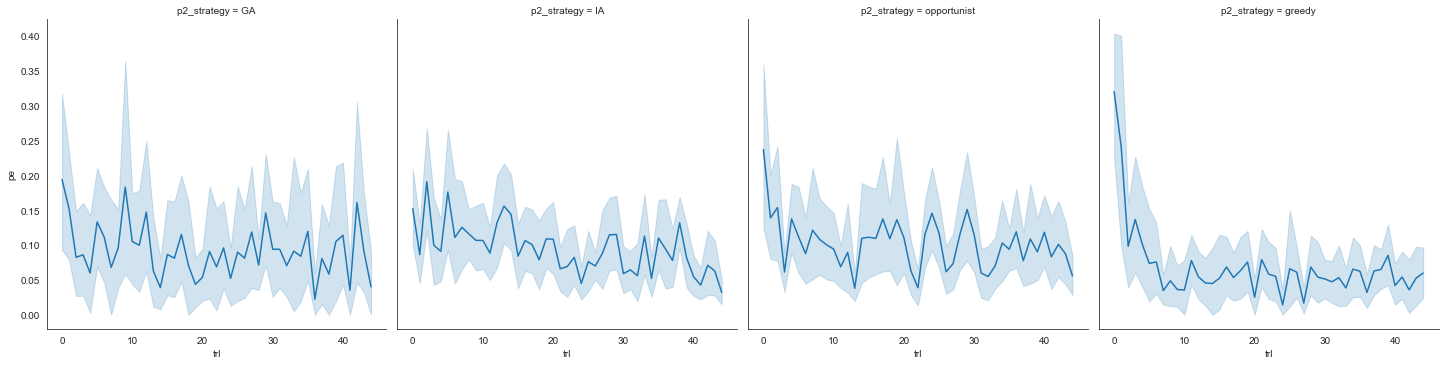

In [6]:
# Make errors between 0 and 1
dat['pe'] = abs((dat.pred/(dat.mult*dat.inv)) - (dat.ret/(dat.mult*dat.inv)))
sns.relplot(x='trl', y='pe', data=dat, col='p2_strategy', kind='line')

When do people write the most? When do they write the least?

In [7]:
dat.reset_index(inplace=True, drop=True)

Is there a relationship between word count and prediction accuracy/investment amount/or multiplier?

# Does information available to participant track the length of their response?

/Users/brandondormes/PycharmProjects/BilliardsApp/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/brandondormes/PycharmProjects/BilliardsApp/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


[[ 1.        -0.0834048]
 [-0.0834048  1.       ]]


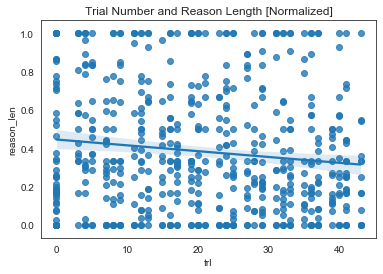

In [20]:
# first, let's see if # of experienced trials is enough
dat_w_resp = dat.loc[dat["reason"] != "n/a"]

resp_lens_list = [len(x.split()) for x in dat_w_resp["reason"]]
dat_w_resp["reason_len"] = resp_lens_list

normalized_dats = []
#
for participant in dat_w_resp.prolific_id.unique():
    normalized_dats.append(dat_w_resp.loc[dat_w_resp["prolific_id"] == participant])

for i in range(len(normalized_dats)):
    normalized_dats[i]["reason_len"] = (normalized_dats[i]["reason_len"]-normalized_dats[i]["reason_len"].min())/(normalized_dats[i]["reason_len"].max()-normalized_dats[i]["reason_len"].min())

dat_w_resp_norm = pd.concat(normalized_dats)

sns.regplot(data=dat_w_resp_norm, x="trl", y="reason_len").set(title="Trial Number and Reason Length [Normalized]")
print(np.corrcoef(dat_w_resp.trl, dat_w_resp.reason_len))

[[nan nan]
 [nan  1.]]


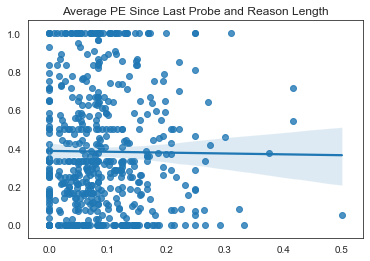

In [25]:
# i want to see if recent prediction error tracks something about response length

# to do that, i'm going to make a stupid number of DFs — each one represents the new data someone got (i.e. new prediction errors) someone got + the reasoning they expressed after getting that data
# dat_pred_err = dat.loc[dat["trl"] != 0] # this line is debatable, i'm just throwing each participant's first trial away since it's pretty noisy

boundary_indices = []

for i in range(len(dat)):
    # just get the indices where we ask for reasons
    if dat["probe_trl"].to_list()[i]:
        boundary_indices.append(i)

dat_list = []

dat["reason_len"] = [np.nan] * len(dat)
dat.loc[dat["probe_trl"], "reason_len"] = dat_w_resp_norm["reason_len"]

# cut up the data into chunks capped by new reason prompts
for i in range(len(boundary_indices) - 1):
    dat_list.append(dat[boundary_indices[i]:boundary_indices[i+1] + 1])

pe_list = []
len_list = []

# make parallel lists that track pe and reason length for a chunk
for item in dat_list:
    pe_list.append(item[:-1].pe.mean())
    len_list.append(item.reason_len.to_list()[-1])

sns.regplot(y=len_list, x=pe_list).set(title="Average PE Since Last Probe and Reason Length")
print(np.corrcoef(len_list, pe_list))

[Text(0.5, 1.0, 'Reason Length by Trustee [Normalized]')]

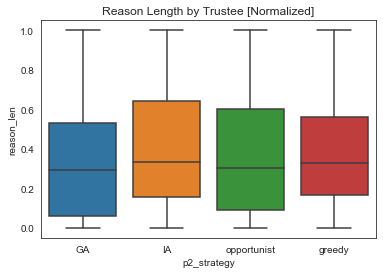

In [26]:
# okay, let's try trustee type

sns.boxplot(data=dat_w_resp_norm, x="p2_strategy", y="reason_len").set(title="Reason Length by Trustee [Normalized]")

[Text(0.5, 1.0, 'Reason Length by Multiplier [Normalized]')]

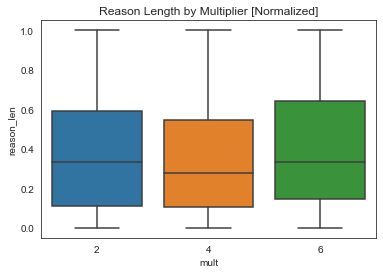

In [27]:
sns.boxplot(data=dat_w_resp_norm, x="mult", y="reason_len").set(title="Reason Length by Multiplier [Normalized]")

[Text(0.5, 1.0, 'Reason Length by Prediction Error [Normalized]')]

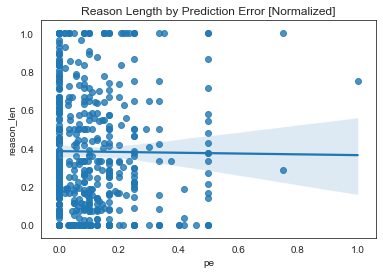

In [28]:
sns.regplot(data=dat_w_resp_norm, x="pe", y="reason_len").set(title="Reason Length by Prediction Error [Normalized]")

/Users/brandondormes/PycharmProjects/BilliardsApp/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[Text(0.5, 1.0, 'Reason Length by Whether Prediction Was Greater Than Return')]

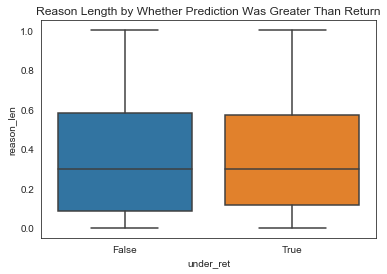

In [29]:
# do things change if we distinguish between trustee under-returns vs over-returns?
dat_pred_dist = dat_w_resp_norm.loc[dat_w_resp["pe"] > 0]
dat_pred_dist["under_ret"] = dat_pred_dist["pred"] > dat_pred_dist["ret"]

sns.boxplot(data=dat_pred_dist, x="under_ret", y="reason_len").set(title="Reason Length by Whether Prediction Was Greater Than Return")